Run producer:
<br>`python producer_green.py`
<br>`python producer_fhv.py`

Let's take a look into CONFLUENT (http://localhost:9021)

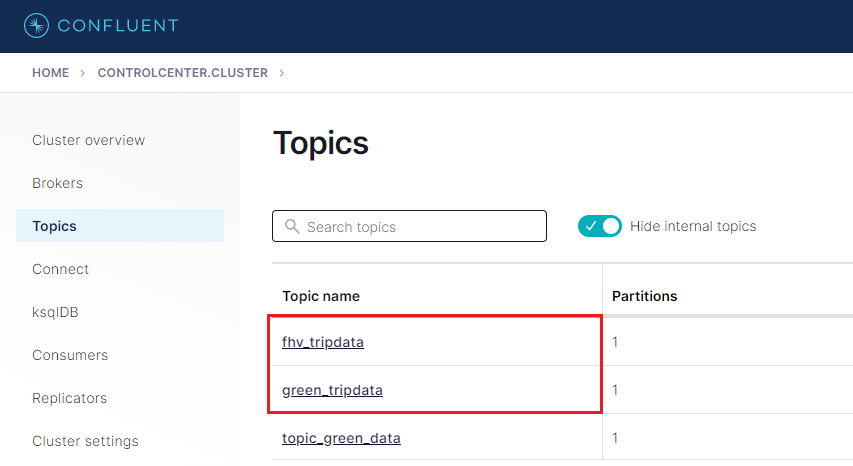

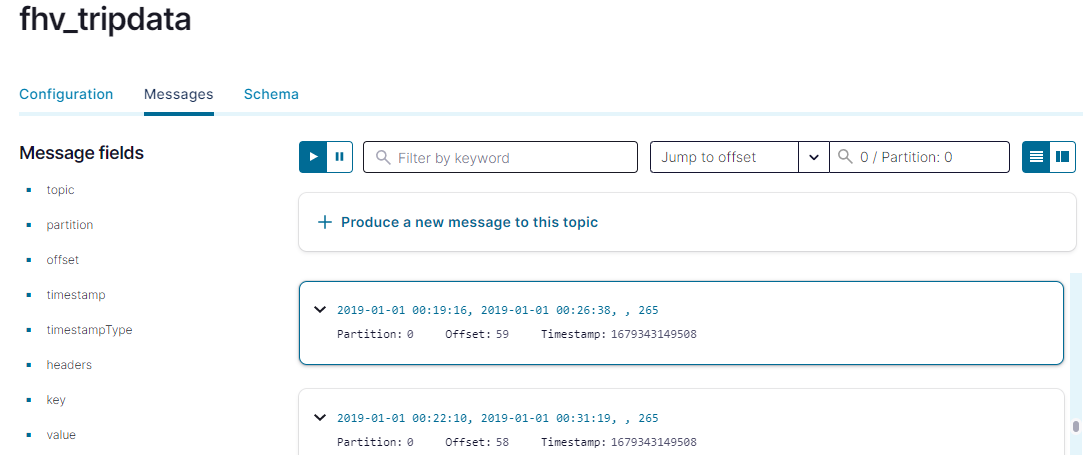

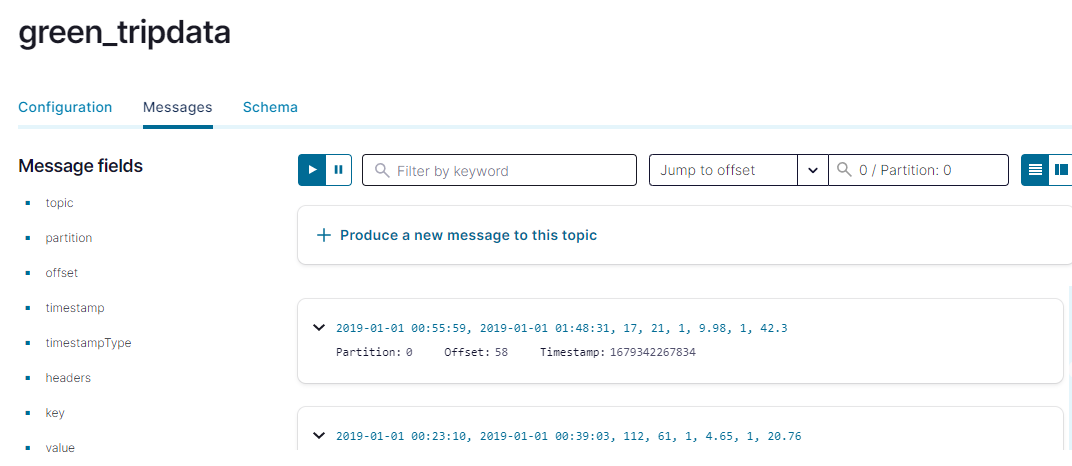

# Prepare Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.1,org.apache.spark:spark-avro_2.12:3.3.1 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession \
    .builder \
    .appName("Spark-Notebook") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/zoomcamp/spark/spark-3.3.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/zoomcamp/.ivy2/cache
The jars for the packages stored in: /home/zoomcamp/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c64a382a-cf7a-49d8-89a0-5b81ba71c63c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.3.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.3.1 in central
	found org.apache.kafka#kafka-clients;2.8.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.32 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.2 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found

23/03/20 20:51:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### 1. Reading from Kafka Stream

through `readStream`

#### 1.1 Raw Kafka Stream

In [3]:
topic_fhv_data = 'fhv_tripdata'

df_kafka_raw_fhv = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092,broker:29092") \
    .option("subscribe", topic_fhv_data) \
    .option("startingOffsets", "earliest") \
    .option("checkpointLocation", "checkpoint") \
    .load()

df_kafka_raw_fhv.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
topic_green_data = 'green_tripdata'

df_kafka_raw_green = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092,broker:29092") \
    .option("subscribe", topic_green_data) \
    .option("startingOffsets", "earliest") \
    .option("checkpointLocation", "checkpoint") \
    .load()

df_kafka_raw_green.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



#### 1.2 Structure Streaming DataFrame

In [5]:
def parse_data_from_kafka_message(df_raw, schema):
    """ take a Spark Streaming df and parse value col based on <schema>, return streaming df cols in schema """
    assert df_raw.isStreaming is True, "DataFrame doesn't receive streaming data"

    df = df_raw.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

    # split attributes to nested array in one Column
    col = F.split(df['value'], ', ')

    # expand col to multiple top-level columns
    for idx, field in enumerate(schema):
        df = df.withColumn(field.name, col.getItem(idx).cast(field.dataType))
    return df.select([field.name for field in schema])

In [6]:
green_schema = T.StructType([
     T.StructField('lpep_pickup_datetime', T.TimestampType()),
     T.StructField('lpep_dropoff_datetime', T.TimestampType()),
     T.StructField('PULocationID', T.IntegerType()),
     T.StructField('DOLocationID', T.IntegerType()),
     T.StructField("passenger_count", T.IntegerType()),
     T.StructField("trip_distance", T.FloatType()),
     T.StructField("payment_type", T.IntegerType()),
     T.StructField("total_amount", T.FloatType()),
])

df_green = parse_data_from_kafka_message(df_raw=df_kafka_raw_fhv, schema=green_schema)

df_green.printSchema()

root
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: float (nullable = true)



In [7]:
fhv_schema = T.StructType([
     T.StructField('pickup_datetime', T.TimestampType()),
     T.StructField('dropOff_datetime', T.TimestampType()),
     T.StructField('PUlocationID', T.IntegerType()),
     T.StructField('DOlocationID', T.IntegerType())
])

df_fhv = parse_data_from_kafka_message(df_raw=df_kafka_raw_fhv, schema=fhv_schema)

df_fhv.printSchema()

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropOff_datetime: timestamp (nullable = true)
 |-- PUlocationID: integer (nullable = true)
 |-- DOlocationID: integer (nullable = true)



In [8]:
def sink_memory(df, query_name, query_template):
    write_query = df \
        .writeStream \
        .queryName(query_name) \
        .format('memory') \
        .start()
    query_str = query_template.format(table_name=query_name)
    query_results = spark.sql(query_str)
    return write_query, query_results

In [9]:
query_name = 'query_green'
query_template = """
SELECT
  PULocationID as pickup_id
FROM
  {table_name}
WHERE
  PULocationID is not null
"""
write_query_green, df_pickup_id_green = sink_memory(df=df_green, query_name=query_name, query_template=query_template)

23/03/20 20:51:27 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-bb6ee915-7227-424c-80ed-e147610f10c6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/03/20 20:51:27 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/03/20 20:51:27 WARN ClientUtils: Couldn't resolve server broker:29092 from bootstrap.servers as DNS resolution failed for broker


23/03/20 20:51:30 WARN ClientUtils: Couldn't resolve server broker:29092 from bootstrap.servers as DNS resolution failed for broker


In [10]:
df_pickup_id_green.show()
write_query_green.stop()

+---------+
|pickup_id|
+---------+
|      140|
|      141|
|      237|
|      162|
|      237|
|      145|
|      261|
|      162|
|       13|
|      249|
|      236|
|      145|
|      171|
|      252|
|      265|
|      229|
|      171|
|       16|
|      252|
|      265|
+---------+
only showing top 20 rows



In [11]:
query_name = 'query_fhv'
query_template = """
SELECT
  PUlocationID as pickup_id
FROM
  {table_name}
WHERE 
  PUlocationID is not null
"""
write_query_fhv, df_pickup_id_fhv = sink_memory(df=df_fhv, query_name=query_name, query_template=query_template)

23/03/20 20:51:40 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-651cbf7e-d3ea-4e56-bd41-7f6503d40764. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/03/20 20:51:40 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/03/20 20:51:40 WARN ClientUtils: Couldn't resolve server broker:29092 from bootstrap.servers as DNS resolution failed for broker
23/03/20 20:51:40 WARN ClientUtils: Couldn't resolve server broker:29092 from bootstrap.servers as DNS resolution failed for broker


In [12]:
df_pickup_id_fhv.show()
write_query_fhv.stop()

+---------+
|pickup_id|
+---------+
|      140|
|      141|
|      237|
|      162|
|      237|
|      145|
|      261|
|      162|
|       13|
|      249|
|      236|
|      145|
|      171|
|      252|
|      265|
|      229|
|      171|
|       16|
|      252|
|      265|
+---------+
only showing top 20 rows



In [14]:
df_total = df_pickup_id_green.union(df_pickup_id_fhv)
df_total.show(10)

+---------+
|pickup_id|
+---------+
|      140|
|      141|
|      237|
|      162|
|      237|
|      145|
|      261|
|      162|
|       13|
|      249|
+---------+
only showing top 10 rows



### Apply aggregations to find most popular pickup location.

In [18]:
df_total.groupBy('pickup_id') \
    .count() \
    .orderBy(F.col('count').desc()) \
    .show(5)

+---------+-----+
|pickup_id|count|
+---------+-----+
|      181|   36|
|      145|   18|
|      252|   18|
|      237|   18|
|      171|   12|
+---------+-----+
only showing top 5 rows

